In [1]:
### DATA ANALYSIS ###
import pandas as pd
import os
import numpy as np
import json

In [2]:
### STATS ###
import statsmodels.stats.multitest as multi

In [3]:
### PLOTTING ###
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
import sys
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')

In [5]:
import myvariant
mv = myvariant.MyVariantInfo()

### results from script: plink-glm.sh

## Get index snps from association results with heritable immune phenotypes driven by nonHLA/KIR regions

### results from script: clump.sh

Compiled values from plink clumping method. P1 threshold: 0..00000008333333, P2 threshold: 0.00001, R2 threshold: 0.10, KB threshold: 1000

In [6]:
def get_clumps(directory,snp_type):
    '''
    Input: directory with all plink .clumped files to be aggregated
    Output: dataframe with INDEX SNP, p-value, association paramter
    '''
    #get clumped files
    files=os.listdir(directory)
    file_lst=[x for x in files if ".clumped" in x]
    
    if snp_type == "index":
    
        #iterate through all clumped files and extract index snps
        snps=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                snps.append(row["SNP"])
                p.append(row["P"])
                assoc.append(x.split(".clump.clumped")[0])
    
        df=pd.DataFrame({"snps":snps,"file":assoc,"p-value":p})
        return(df)
    
    if snp_type == "all":
        snps=[]
        indexsnp=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                for y in row["SP2"].split("(1),"):
                    snps.append(y)
                    indexsnp.append(row["SNP"])
                    p.append(row["P"])
                    assoc.append(x.split(".clump.clumped")[0])
                
        df=pd.DataFrame({"indexsnps":indexsnp,"snps":snps,"file":assoc,"p-value":p})
        df=df[~(df["snps"]=="")]
        df=df[~(df["snps"]=="NONE")]
        df["snps"]=df["snps"].str.split("(").str[0]
        return(df)

In [7]:
def map_rsid(x):
    '''
    Input: SNP format (chr:bp:minor:major)
    Output: tuple (variant,rsid)
    '''
    try:
        var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[2]+">"+x.split(":")[3]
        rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
    except:
        try:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
        except:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=""
    
    return (var,rs)
  

In [6]:
df=pd.read_csv("../../snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [9]:
df[df["snps"]=="1:88665329:T:C"]

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,gwas
223,1:88665329:T:C,CCBL2,immunomodulators,0.1799,chr1:g.88665329T>C,rs1932757,-0.126175,0.021926,9.040830e-09,T,C,-0.133589,0.022174,1.781330e-09,-0.142422,0.021816,7.101700e-11,7.101700e-11,736126.0,['Cognitive test performance']


In [13]:
pheno=pd.read_csv("../data/SupplmentalTable1.csv")

In [16]:
pheno[pheno["phenotypes"]=="IRF4"]

,phenotypes,category,source


In [8]:
#get index snps
tpm_snps=get_clumps("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/clump/tpm","index")
firebrowse_snps=get_clumps("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/clump/firebrowse","index")
pancan_snps=get_clumps("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/clump/pancanatlas","index")

In [9]:
#combine index snps from all 3 RNA processing pipelines
all_snps=tpm_snps.append(firebrowse_snps)
all_snps=all_snps.append(pancan_snps)

### make snps extract file

In [10]:
extract=all_snps["snps"].unique().tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in all_snps["snps"].unique().tolist()]
extract=pd.DataFrame({"snps":extract})
extract.to_csv("../../snp-tables/extract-immune-microenvironment-nonhla-snps.txt",header=None,index=None,sep="\t")

## Map Immune Phenotype Category

In [11]:
#map to categories
with open('../data/pheno_dictionary.json', 'r') as f:
    pheno_dict = json.load(f)
all_snps["category"]=all_snps["file"].map(pheno_dict)

## Map MAF

In [12]:
#map to minor allele frequency
maf=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.maf.frq",delim_whitespace=True)
mp_maf=dict(zip(maf["SNP"],maf["MAF"]))
all_snps["maf"]=all_snps["snps"].map(mp_maf)

## Map to RSID

In [13]:
#map to rsid
all_snps['variant'] = all_snps['snps'].apply(lambda x: map_rsid(x)[0])
all_snps['rsid'] = all_snps['snps'].apply(lambda x: map_rsid(x)[1])

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

In [14]:
all_snps=all_snps[["snps","file","category","maf","variant","rsid"]].drop_duplicates()

## Map to 3 RNA processing pipeline beta/SE

### Run extract-snps.sh

In [15]:
def compiled(directory):
    files=os.listdir(directory)
    
    compiled=pd.DataFrame()
    
    for x in files:
        try:
            df=pd.read_csv(directory+"/"+x,delimiter="\t",header=None)
            df_filt=df[df[6]=="ADD"]
            df_filt["file"]=x.split(".sig.snps")[0]
            compiled=compiled.append(df_filt)
        except:
            print(x)
    
    return(compiled)

In [16]:
tpm=compiled("../associations/filtered/tpm")
firebrowse=compiled("../associations/filtered/firebrowse")
pancan=compiled("../associations/filtered/pancanatlas")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
tpm=tpm.rename(columns={2:"snps",8:"tpm beta",9:"tpm SE",11:"tpm P",3:"REF",4:"ALT"})
firebrowse=firebrowse.rename(columns={2:"snps",8:"firebrowse beta",11:"firebrowse P",9:"firebrowse SE"})
pancan=pancan.rename(columns={2:"snps",8:"pancan beta",11:"pancan P",9:"pancan SE"})

In [18]:
total=pd.merge(tpm[["snps","tpm beta","tpm SE","tpm P","file","REF","ALT"]],firebrowse[["snps","firebrowse beta","firebrowse SE","firebrowse P","file"]],on=["snps","file"])
total=pd.merge(total,pancan[["snps","pancan beta","pancan SE","pancan P","file"]],on=["snps","file"])

In [19]:
total["tpm P"]=total["tpm P"].astype(float)
total["firebrowse P"]=total["firebrowse P"].astype(float)
total["pancan P"]=total["pancan P"].astype(float)

In [21]:
snps_annot=pd.merge(all_snps,total,on=["snps","file"],how="left")
print(snps_annot.shape)
snps_annot.head()

(482, 17)


,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P
0,1:249111684:T:C,SH3BP5L,immunomodulators,0.13030,chr1:g.249111684T>C,rs7419176,-0.138887,0.024709,1.971340e-08,T,C,-0.156999,0.024937,3.244430e-10,-0.153749,0.024547,3.982010e-10
1,13:108991004:A:G,TNFSF13B,immunomodulators,0.49380,chr13:g.108991004A>G,rs9520845,0.094528,0.016543,1.148140e-08,A,G,0.108154,0.016762,1.177210e-10,0.108267,0.016466,5.204390e-11
2,19:55175740:C:T,LILRB4,immunomodulators,0.37430,chr19:g.55175740C>T,rs3745871,0.552741,0.016038,7.971420e-241,C,T,-0.042462,0.017650,1.616310e-02,-0.048756,0.017292,4.823190e-03
3,19:55175983:T:A,LILRB4,immunomodulators,0.05939,chr19:g.55175983T>A,rs7253814,-0.588260,0.035009,3.632880e-62,T,A,0.109191,0.036245,2.599720e-03,0.111202,0.035470,1.725110e-03
4,19:55145546:T:G,LILRB4,immunomodulators,0.11450,chr19:g.55145546T>G,rs2098952,-0.288007,0.025738,7.953270e-29,T,G,-0.057270,0.026471,3.053910e-02,-0.052444,0.025963,4.342880e-02


## Check for snps that pass significance thresholds

In [24]:
snps_annot["p-value"]=snps_annot[["tpm P", "firebrowse P","pancan P"]].min(axis=1)

In [25]:
threshold=.00000005
"{} snps pass {} threshold".format(len(snps_annot[snps_annot["p-value"]<threshold]),threshold)

'443 snps pass 5e-08 threshold'

In [26]:
threshold=.00000005/120
"{} snps pass {} threshold".format(len(snps_annot[snps_annot["p-value"]<threshold]),threshold)

'296 snps pass 4.166666666666666e-10 threshold'

## Check for unique number of snps

In [27]:
"{} unique snps out of {} associations".format(len(snps_annot["snps"].unique()),len(snps_annot))

'475 unique snps out of 482 associations'

## Make dictionary of snps and phenotype associations

In [28]:
snp_pheno={}

for x in snps_annot["snps"].unique():
    pheno=snps_annot[snps_annot["snps"]==x]["file"].unique().tolist()
    snp_pheno[x]=pheno

In [29]:
import json
with open('../data/snp_association.json', 'w') as json_file:
    json.dump(snp_pheno, json_file)

## Check for number of snps per phenotypes

In [30]:
snps_counts=snps_annot["file"].value_counts().reset_index()
snps_counts=snps_counts[snps_counts["file"]>1]

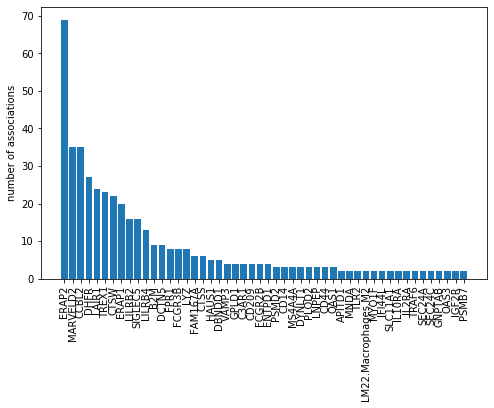

In [31]:
f=plt.figure(figsize=(8,5))
plt.bar(snps_counts["index"].tolist(),snps_counts["file"].tolist())
plt.ylabel("number of associations")
plt.xticks(rotation=90)
plt.savefig("../plots/num.snps.phenotypes.pdf")

## Identify cis-trans snps with UCSC Annotation file

### Get annotations

In [37]:
ucsc=pd.read_csv("/cellar/users/mpagadal/Data/resources/annotations/ucsc_annot_20191016",delimiter="\t")
print(ucsc.shape)
ucsc.head()

(82960, 12)


,#hg19.knownGene.name,hg19.knownGene.chrom,hg19.knownGene.strand,hg19.knownGene.txStart,hg19.knownGene.txEnd,hg19.knownGene.cdsStart,hg19.knownGene.cdsEnd,hg19.knownGene.exonCount,hg19.knownGene.exonStarts,hg19.knownGene.exonEnds,hg19.knownGene.proteinID,hg19.kgXref.geneSymbol
0,uc001aaa.3,chr1,+,11873,14409,11873,11873,3,"11873,12612,13220,","12227,12721,14409,",NaN,DDX11L1
1,uc010nxr.1,chr1,+,11873,14409,11873,11873,3,"11873,12645,13220,","12227,12697,14409,",NaN,DDX11L1
2,uc010nxq.1,chr1,+,11873,14409,12189,13639,3,"11873,12594,13402,","12227,12721,14409,",B7ZGX9,DDX11L1
3,uc009vis.3,chr1,-,14361,16765,14361,14361,4,"14361,14969,15795,16606,","14829,15038,15942,16765,",NaN,WASH7P
4,uc009vjc.1,chr1,-,16857,17751,16857,16857,2,"16857,17232,","17055,17751,",NaN,WASH7P


In [38]:
ucsc["cis1"]=ucsc["hg19.knownGene.txStart"]-1000000
ucsc["cis2"]=ucsc["hg19.knownGene.txStart"]+1000000

In [39]:
ucsc.loc[(ucsc['cis1'] < 0), 'cis1'] = 0
ucsc.loc[(ucsc['cis1'] < 0), 'cis2'] = 0

In [46]:
ucsc["hg19.kgXref.geneSymbol"]=ucsc["hg19.kgXref.geneSymbol"].replace("CTSL1","CTSL")

In [47]:
#check if any phenotypes don't have gene location
miss=[]

for x in snps_annot["file"].unique():
    x=x.replace(".","-")
    if x not in ucsc["hg19.kgXref.geneSymbol"].tolist():
        miss.append(x)

In [48]:
miss

['LM22-Macrophages-M2']

In [49]:
tss=[]

for i,row in snps_annot.iterrows():
    c="chr"+row["snps"].split(":")[0]
    b=float(row["snps"].split(":")[1])
    #filter to chromosome
    filt=ucsc[ucsc["hg19.knownGene.chrom"]==c]
    #find difference between 1MB on each side of TSS
    filt["diff1"]=b-filt["cis1"]
    filt["diff2"]=filt["cis2"]-b
    #get cis snps
    filt=filt[(filt["diff1"]>0)&(filt["diff2"]>0)]
    #get gene name
    filt=filt[filt["hg19.kgXref.geneSymbol"]==row["file"]]
    filt["TSS distance"]=filt["hg19.knownGene.txStart"]-b
    lst=filt["TSS distance"].tolist()
    try:
        tss.append(max(set(lst), key = lst.count))
    except:
        tss.append("nan")
        
snps_annot["cis tss"]=tss

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [50]:
#separate into phenotypes with gene information
na=len(snps_annot[snps_annot["file"].isin(["dice.M2","LM22.Macrophages.M2"])])/len(snps_annot)
nonna=snps_annot[~snps_annot["file"].isin(["dice.M2","LM22.Macrophages.M2"])]

In [51]:
trans=len(nonna[nonna["cis tss"]=="nan"])/len(snps_annot)
cis=len(nonna[nonna["cis tss"]!="nan"])/len(snps_annot)

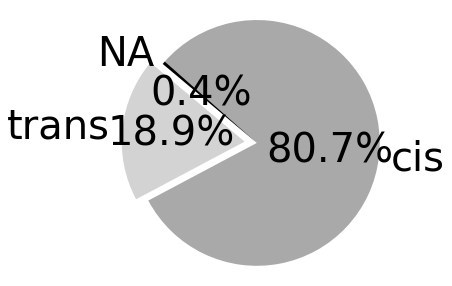

In [52]:
labels = 'trans', 'cis',"NA"
sizes = [trans,cis,na]
colors = ['lightgray', 'darkgray',"black"]
explode = (0.1, 0.0,0)  # explode 1st slice
plt.figure(figsize=(5,5))
mpl.rcParams['font.size'] = 40
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)
 
plt.axis('equal')
plt.savefig("../plots/cis.trans.pdf")

## Export annotated snps

In [53]:
snps_annot.to_csv("../../snp-tables/immune-microenvironment-nonhla.tsv",index=None,sep="\t")

## Analyze association beta variation amongst different TCGA RNA processing methods

### Output from extract-snps.sh

In [54]:
snps_annot["beta error"]=(snps_annot[['tpm beta','firebrowse beta','pancan beta']].std(axis = 1))/3
snps_annot["beta mean"]=(snps_annot[['tpm beta','firebrowse beta','pancan beta']].mean(axis = 1))

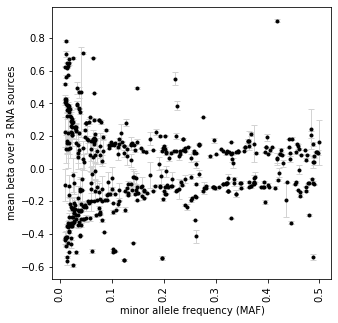

In [55]:
f=plt.figure(figsize=(5,5))
mpl.rcParams['font.size'] = 10
plt.errorbar(snps_annot["maf"], snps_annot["beta mean"], yerr=snps_annot["beta error"], fmt='.', color='black',
             ecolor='lightgray', elinewidth=1, capsize=3);
plt.xticks(rotation=90)
plt.ylabel("mean beta over 3 RNA sources")
plt.xlabel("minor allele frequency (MAF)")
plt.savefig('../plots/association.errors.pdf')